# Hybrid Monte Carlo
## 2-Dimensional Schwinger Model

The 2-Dimensional Schwinger Model is highly interesting as it provides certain features that QCD has while being analytically as well as computationally much simpler.
It is defined by the action 
\begin{equation}
\begin{aligned}
    S\left(\Psi,\Psi^\dagger,A\right) &= \frac{2}{g^2}\int \Psi^\dagger( \textbf{x}) \left(i\sigma^\mu D_\mu( \textbf{x}) - m\right) \Psi(\textbf{x}) + F^{\mu\nu}( \textbf{x})F_{\mu\nu}( \textbf{x}) ~d^2 \textbf{x}\\
                                      &= S_F\left(\Psi,\Psi^\dagger,A\right) + S_G\left(A\right)
\end{aligned}
\end{equation}
where $ \textbf{x} = (t,x)$ denotes the 2 vector with one temporal $(t)$ and one spatial $(x)$ direction (1+1 dimensional), $\Psi( \textbf{x})$ describes a two component spinor and $A_\mu(\textbf{x})\in \mathfrak{u}(1)$ represents the photon (scalar) field. 
Furthermore, $D_\mu(\textbf{x}) = \partial_\mu - i A_\mu(\textbf{x})$ is the Dirac operator and $F_{\mu\nu}(\textbf{x}) = \partial_\mu A_\nu(\textbf{x}) - \partial_\nu A_\mu(\textbf{x})$ is the photon field strength tensor. 
Moreover, $\sigma_\mu$ are the Pauli matrices. This action can be identified as a two dimensional QED. 

We will consider a lattice discretized theory. The fermion fields live on the sites of the lattice, the gauge fields live on the links. This week we only consider the pure gauge part to understand how an HMC algorithm can be implemented. For that, we introduce so-called "link variables" $U_\mu(\textbf{n}) = e^{\mathrm{i} a A_\mu(a \textbf{n})}\in U(1)$, hence the $U$ are just complex phases. Note that the link $U_\mu(n) = U(n, n+\hat{\mu})$ connects the sites $n$ and $n+\hat{\mu}$, where $\hat{\mu}$ is a unit step on the lattice in $\mu$ direction. The gauge action can now be defined using the plaquette:
<!-- 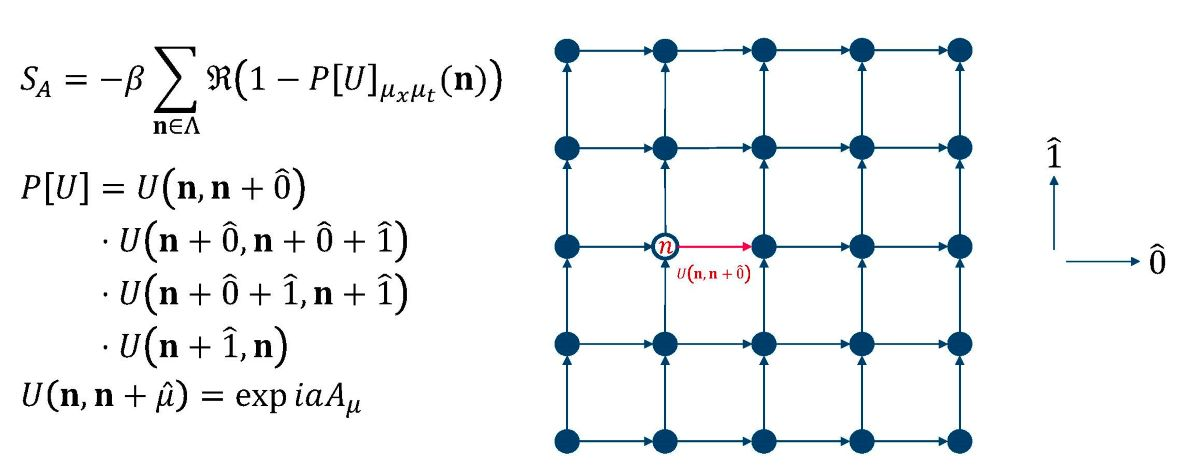
-->
<div>
    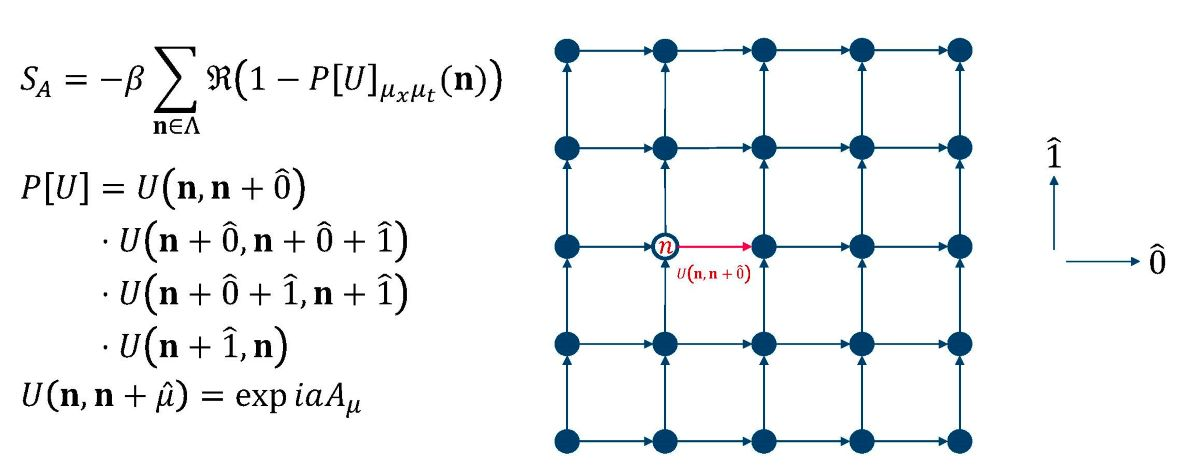
</div>

Now, we can write (the reason does not matter here) $U(n,n-\hat{\mu}) = U^\dagger(n-\hat{\mu},n)$, i.e. we can flip the direction, if we take the adjoint link. Similarly $U_{-\mu}(n+\hat{\mu}) = U^\dagger_\mu(n)$.

<!-- 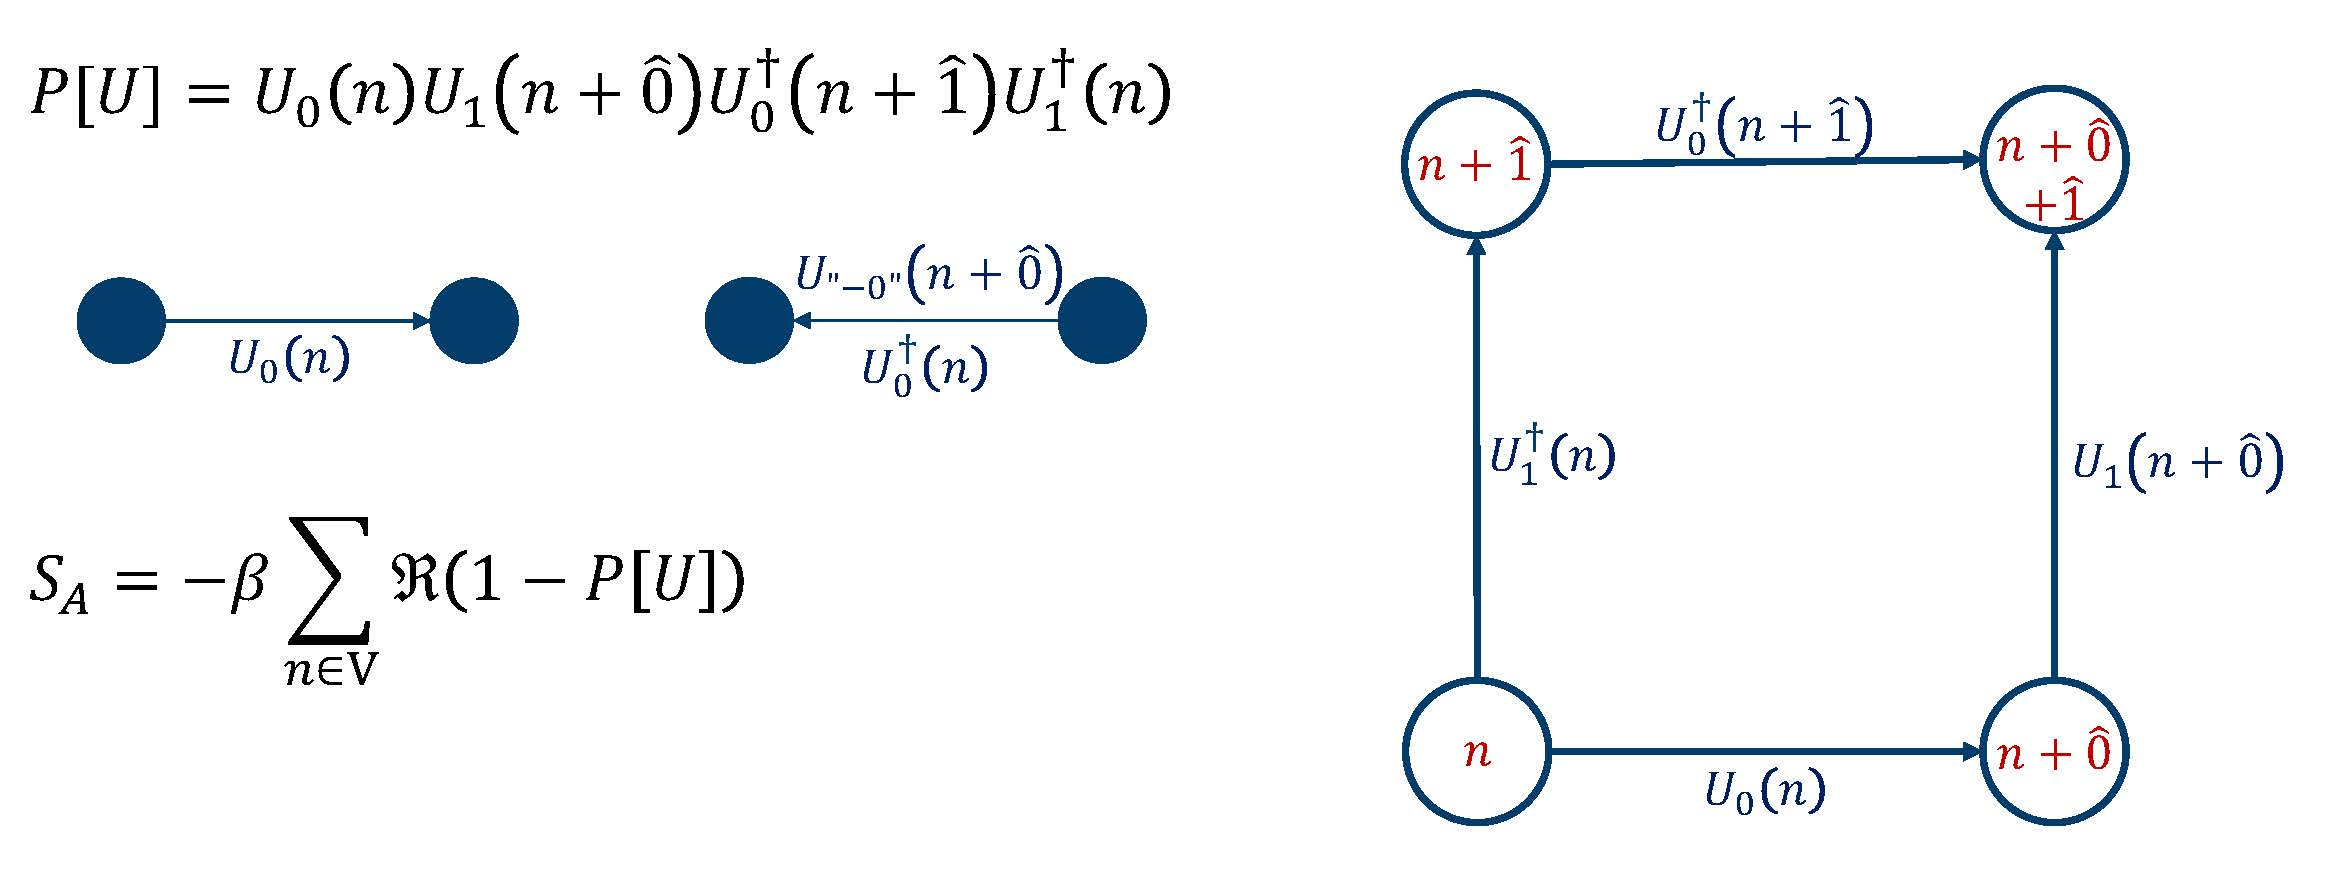
-->
<div>
    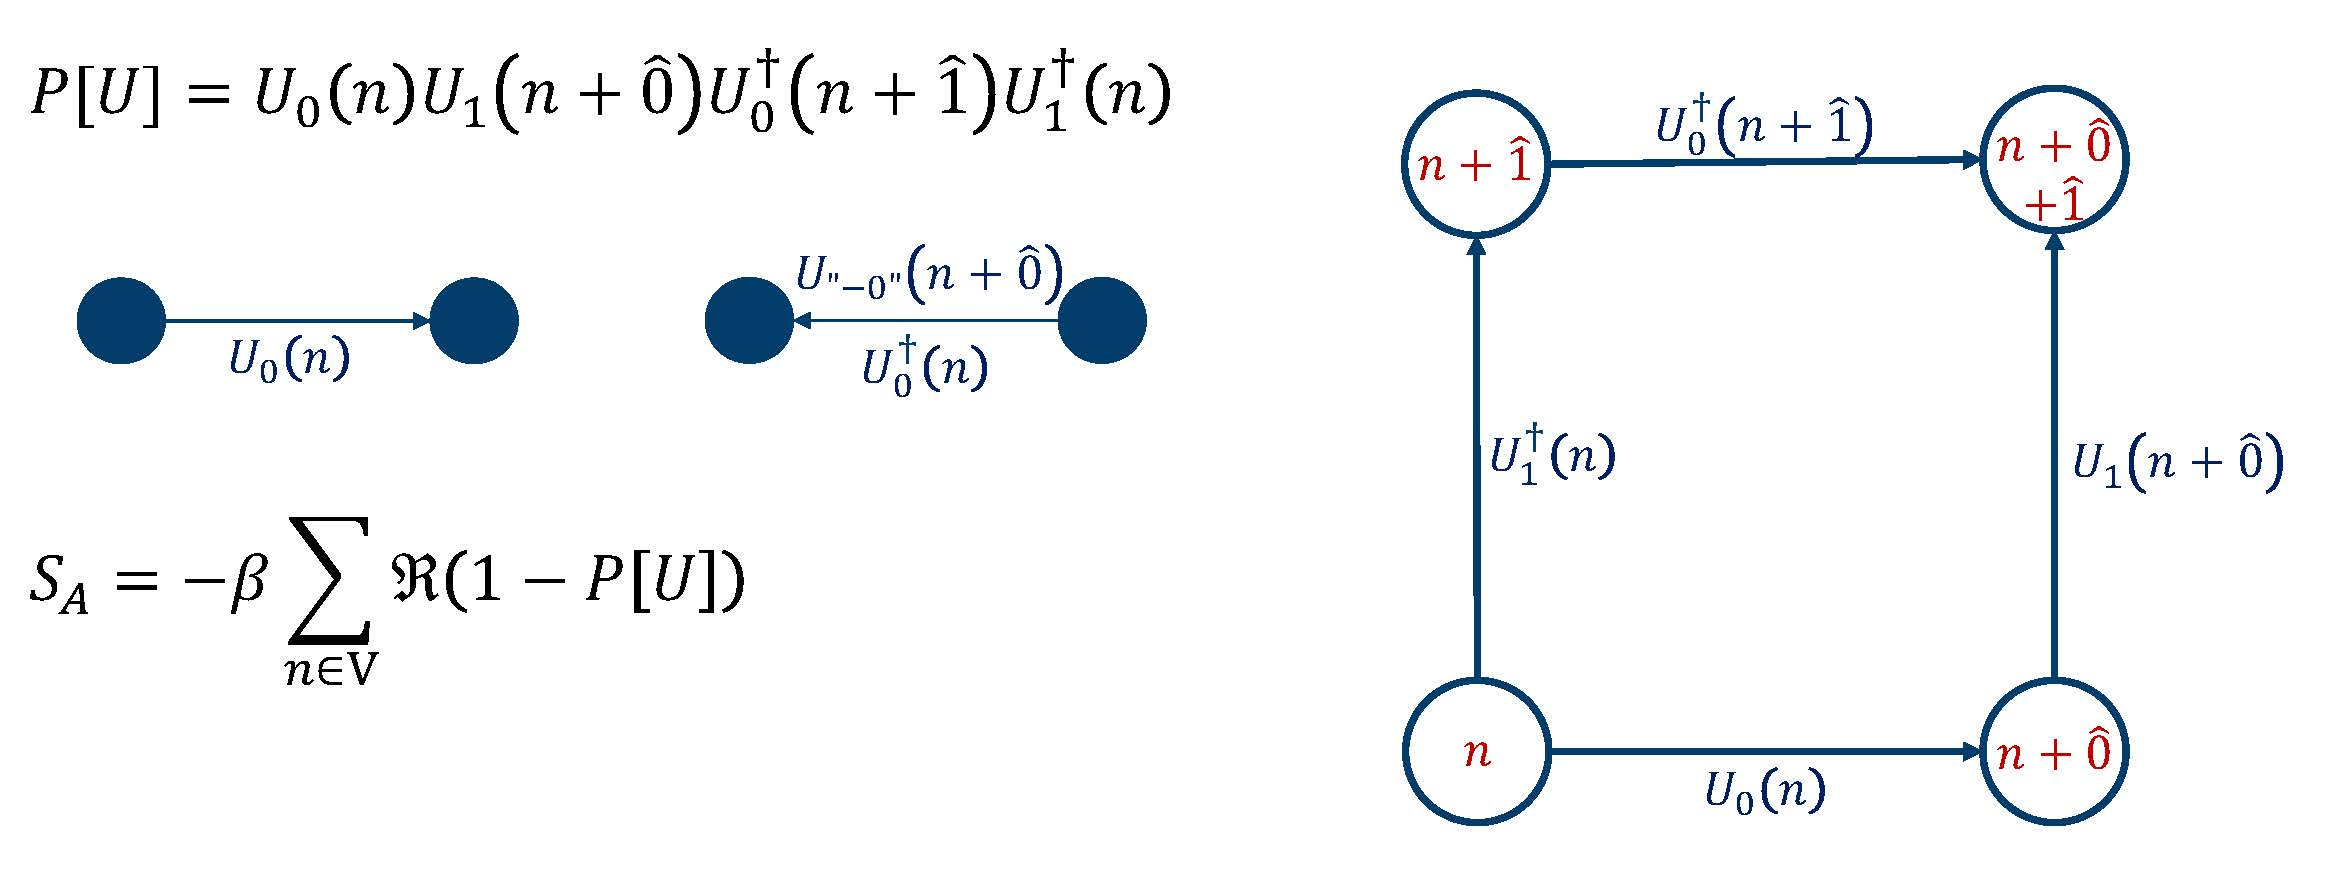
</div>


To summarize: we will only consider the (Wilson) gauge action (see $S_A$ above, modulo some factor)
\begin{equation}
    S_G\left(U\right) = 2\beta \sum_{\textbf{n}\in \Lambda} \Re \left(\mathbb{1} - P\left[U\right]_{\mu_x\mu_t}(\textbf{n})\right) 
\end{equation}
with the so-called plaquette $P$
\begin{equation}
P\left[U\right]_{\mu\nu}\left(\textbf{n}\right) = U_{\mu}(\textbf{n}) \cdot U_{\nu}(\textbf{n}+\hat{\mu}) \cdot U_{\mu}^\dagger(\textbf{n}+\hat{\nu}) \cdot U_{\nu}^\dagger(\textbf{n}).
\end{equation}
Identify the bare coupling $\beta = 1/g^2$.

In [2]:
# Cell 1 
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# for your convenience define 
mu_t = 0 
mu_x = 1

#### Exercise 7.1 The Wilson Gauge Action

Even this simple example HMC turns out to be fairly expensive. Thus we have to think about optimizing the code to a certain extend.
Python's main bottleneck in number crunching comes from non optimized loops i.e. loops which are not compiled. Python fortunately has a rich set of libraries which can circumvent this problem such as numpy. 

##### 7.1.a) 
Implement the plaquette using no explicitly written loops.

##### 7.1.b)
Implement the Action using the plaquette developed in a).

Hint:

* Use `numpy.ndarray` (https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html
* Use Slicing operations (https://numpy.org/doc/stable/reference/arrays.indexing.html)
    * e.g. `x[:,:,1]` returns a view on the two dimensional subarray
* Use `numpy.roll` (https://numpy.org/doc/stable/reference/generated/numpy.roll.html)

In [3]:
# Cell 2
def g_plaquette(config,mu,nu):
    # Exercise 7.1.a)
    # =============================================================================================================
    # config is supposedc to be the 2dim grid of the field U
    
    return (config[:, :, mu]
            * np.roll(config[:, :, nu], axis=mu, shift=1)
            * np.roll(config[:, :, mu], axis=nu, shift=1).conjugate()
            * config[:, :, nu].conjugate())
    # =============================================================================================================

In [4]:
# Cell 3
np.random.seed(1234) # this call is local to this cell do not change the seed!!!

# generage a random configuration for Nt = Nx = 3
test_gauge = np.exp(1j*np.random.randn(3,3,2)) 

print(np.sum(g_plaquette(test_gauge,mu_t,mu_t))) # (9-2.5673907444456745e-16j)
print(np.sum(g_plaquette(test_gauge,mu_t,mu_x))) # (0.7952904825671003+4.232164745727907j)
print(np.sum(g_plaquette(test_gauge,mu_x,mu_x))) # (9+3.252606517456513e-17j)
print(np.sum(g_plaquette(test_gauge,mu_x,mu_t))) # (0.795290482567101-4.232164745727906j)

# There seems to be a discrepancy, but only with values under e-16. So maybe its just a floating point precision issue?

(9+2.0977062647180296e-17j)
(0.7952904825671008+4.232164745727907j)
(9+4.222396193121513e-17j)
(0.7952904825671008-4.232164745727907j)


In [5]:
# Cell 4
def g_action(beta,config):
    # Exercise 7.1.b)
    # =============================================================================================================
    return 2 * beta * (1 - g_plaquette(config, mu_t, mu_x)).real.sum()
    # =============================================================================================================

In [6]:
# Cell 5

print(g_action(1,test_gauge)) # 16.4094190348658

16.4094190348658


To check that your code is sufficiently fast, benchmark it in the following cell. 
You should obtain timings of a similar order as

* 30.7 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [27]:
%%timeit
# Cell 6
g_action(1/3,test_gauge)

16.8 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now that the system we want to investigate is well defined let us recall what the HMC was. Technically, the pure gauge part is ultra local i.e. only the Plaquette is involved, hence there are more efficient update algorithms, but we use this for illustration purposes only and use HMC. 

The basic idea is to apply Molecular Dynamics to update the fields. Recall, this means to generate a new configuration out of an old configuration by evolving it through the __classical Hamilon's equation of motion__ 
(EoM). (__Note:__ we are altering the notation a bit with respect to the lecture, avoiding e.g. $P$ appearing too often.)
\begin{equation}
\begin{aligned}
    \frac{\partial\pi}{\partial\tau_{MD}} &= - \frac{\partial \mathcal{H}}{\partial \Phi} \\[1em] 
    \frac{\partial\Phi}{\partial\tau_{MD}} &= \frac{\partial \mathcal{H}}{\partial \pi}
\end{aligned}
\end{equation}
Again our Hamilton 
\begin{equation}
    \mathcal{H} = \frac{1}{2} \pi^2 + S\left[\Phi\right]
\end{equation}
is using the action $S\left[\Phi\right]$ on a field $\Phi$ e.g. $\Phi = U \in U(1)$ as potential. $\tau_{MD}$ denotes the Molecular dynamics time and $\pi = \frac{\partial \mathcal{H}}{\partial \pi}$ is called a momentum field.

#### Exercise 7.2 Change of Probability Distribution

Show that 
\begin{equation}
    \left\langle O \right\rangle_{\Phi} = 
    \frac{
        \int O\left[\Phi\right] e^{S\left[\Phi\right]} \mathcal{D}\left[\Phi\right]
    }{
        \int e^{S\left[\Phi\right]} \mathcal{D}\left[\Phi \right]
    } 
    =
    \frac{
        \int O\left[\Phi\right] e^{\mathcal{H}\left[\Phi,\pi\right]} \mathcal{D}\left[\Phi\right]\mathcal{D}\left[\pi\right]
    }{
        \int e^{\mathcal{H}\left[\Phi,\pi\right]} \mathcal{D}\left[\Phi\right]\mathcal{D}\left[\pi\right]
    }
    = \left\langle O \right\rangle_{\Phi,\pi}
\end{equation}

Hint: 

* If you are not familiar handling path integrals, think about probability distributions 
    
Now this exercise shows that the probability density $e^{-S}/Z_S$ is equivalent to $e^{-\mathcal{H}}/Z_\mathcal{H}$ under the expectation value.

#### Solution 7.2---------------------------
The observable $O$ does only depend on the field $\Phi$ so that the expecation value is 
$$
    \frac{1}{Z[\Phi]}\int\mathcal D[\Phi] O[\Phi]e^{-S[\Phi]}
$$
where $Z[\Phi] = \int \mathcal D[\Phi]e^{-S[\Phi]}$. We now introduce as a new varialbe the momenta $\pi$ with $Z[\pi] = \int \mathcal D[\pi]e^{-\pi^2 / 2}$. 
With this we can rewrite the expectation value to
$$
    \frac{1}{Z[\Phi]Z[\pi]}\int\mathcal D[\Phi] O[\Phi]e^{-S[\Phi]}Z[\pi] = \frac{1}{Z[\Phi, \pi]} \int \mathcal D[\Phi]\mathcal D[\pi]e^{-\mathcal H[\Phi, \pi]}
$$
with 
$$
    \mathcal H[\Phi, \pi] = \frac{\pi^2}2 + S[\Phi]
$$

We integrate the EoM numerically using an integrator such as the leapfrog algorithm. 
For the leapfrog we need to compute the force, i.e. in this case 
\begin{equation}
    F(U) = -\frac{\partial \mathcal{H}(U,\pi)}{\partial U}.
\end{equation}

#### Exercise 7.3 Force
##### 7.3.a)
Show that the force is given by
\begin{equation}
F_\mu(\textbf{n}) \equiv \frac{\partial \mathcal{H}(U,\pi)}{\partial U_{\mu}(\textbf{n})} 
         = -2 \beta \Im\left[ U_\mu(\textbf{n}) K_{\mu}(\textbf{n})\right]
\end{equation}
where 
\begin{equation}
\begin{aligned}
    K_{\mu}(\textbf{n}) = \left.U_{\nu}(\textbf{n}+\hat{\mu}) \cdot U_{\mu}^\dagger(\textbf{n}+\hat{\nu}) \cdot U_{\nu}^\dagger(\textbf{n}) 
                        + U_{\nu}^\dagger(\textbf{n}+\hat{\mu}-\hat{\nu}) \cdot U_{\mu}^\dagger(\textbf{n}-\hat{\nu}) \cdot U_{\nu}(\textbf{n}-\hat{\nu})\right\vert_{\nu\neq\mu}
\end{aligned}
\end{equation}
is the staple (implemented in Cell 7).
Recall that the Hamiltonian is given with:
\begin{equation}
    \mathcal{H}(U,\pi) = \frac{1}{2} \pi^2 +2\beta \sum_{\textbf{n}\in \Lambda}  \Re \left( 1 - P\left[U\right]_{\mu_x\mu_t}(\textbf{n})\right)
\end{equation}
with the plaquette $P\left[U\right]_{\mu\nu}\left(\textbf{n}\right) = U_{\mu}(\textbf{n}) \cdot U_{\nu}(\textbf{n}+\hat{\mu}) \cdot U_{\mu}^\dagger(\textbf{n}+\hat{\nu}) \cdot U_{\nu}^\dagger(\textbf{n})$

##### 7.3.b)
What mathematical object is the force?
Hint:

* The Gauge Link is a $U(1)$ element.

###### Hint: Excurse Lie Groups and Lie Algebras

Recall that $U\in U(1)$ is a Lie group element. Hence it is not trivial how to compute such derivatives. To see how this proceeds (extendable for SU(N) such that you can use the same in Latice QCD) consider the general case of a Lie Group $G$  with generators $T^{(a)}\in\mathfrak{g}$, $a=1,2,...,dim(G)\equiv N$.
Then 
\begin{equation}
\forall U\in G: U = e^{\mathrm{i} \omega_a T^a} 
\end{equation}
(Einstein sum convention applied)

Generally the derivative of $f:G \to \mathbb{F}$ from the group into some Field $F$ (e.g. action) can be defined as a direct application of the one parameter theorem (see e.g. Kristopher Tapp, Differential Geometry of Curves and Surfaces, DOI:10.1007/978-3-319-39799-3) by 
\begin{equation}
    \frac{df(U)}{dU} = \sum_{a=1}^{N} \frac{df(U(\omega_a))}{d\omega_a} T^a
\end{equation}
where we can parametrize 
\begin{equation}
    \frac{df(U(\omega_a))}{d\omega_a} = \left.\frac{d f(\gamma(\omega))}{d\omega}\right\vert_{\omega=0}
\end{equation}
for an appropriate path $\gamma: \mathbb{R} \to G$. 
In particular one can use 
\begin{equation}
    \gamma(\omega) = e^{i \omega T^a} U
\end{equation}
yielding the convenient form 
\begin{equation}
\frac{df(U)}{dU} = \sum_{a=1}^{N} \left.\frac{d f(e^{i \omega T^a} U)}{d\omega}\right\vert_{\omega=0}
\end{equation}

Now this formula simplifies greatly in the case of $U(1)$ as $dim(U(1)) = 1$ to 
\begin{equation}
\frac{df(U)}{dU} = \left.\frac{d f(e^{i \phi } U)}{d\phi}\right\vert_{\phi=0}
\end{equation}


#### Solution 7.3)----------------------

##### 7.3.a)
$\renewcommand\nosam{\bigg|_{\mu\neq\nu}}$

In the following, 
$$
    S_{\mu\nu}(U) = 2\beta\sum_{\bold n} \real(1 - P[U]_{\mu\nu}(\bold n)) \propto
        - \beta\sum_{\bold n}(P[U]_{\mu\nu}(\bold n) + P^\dagger[U]_{\mu\nu }(\bold n))
$$
where the constant term was neglected because it is not important after taking the derivative. Also, 
$P[U]$ does not mean that $P$ depends on the scalar $U$, but on 4 neighboring $U$, so it's a function 
of 4 scalar values. We also see that $P^\dagger_{\mu\nu}[U](\bold n) = P_{\nu\mu}[U](\bold n)$, so that 
the action is a symmetric matrix, which means that is does not matter if we take the derivate in terms 
of $U_{\mu}(\bold n)$ or $U_{\nu}(\bold n)$.
With the Hamiltonian 
$$
    \mathcal H(U, \pi) = \frac{\pi^2}{2} + S_{\mu\nu}(U)\bigg|_{\mu\neq \nu}
$$
The force is 
$$
    F_\mu(n) = -\frac{\partial(\pi^2/ 2 + S_{\mu\nu}(U))}{\partial U_\mu(n)}\bigg|_{\mu\neq\nu} 
    = -\frac{\partial S_{\mu\nu}(U)}{\partial U_\mu(n)}\nosam =
     -\frac{\partial S(e^{i\phi_\mu(\bold n)}U_\mu(\bold n), \text{other }U)}{\partial \phi_\mu(\bold n)}\bigg|_{\phi_\mu=0}
$$
In the last expression it is important that we treat $S$ only as a function of $U_\mu(\bold n)$. For easier calculation, we use a trick
and add a phase not only to $U_\mu(\bold n)$, but for every $U_\mu$, which we can do because after setting $\phi_\mu = 0$ 
it does not make a difference. For example:
$$
    P_{\mu\nu}[e^{i\phi_\mu}U_\mu, U_\nu](\bold n) = e^{i(\phi_\mu(\bold n) - \phi_\mu(\bold n + \hat\nu))}P_{\mu\nu}[U](\bold n)
$$
which yields 
$$
    \frac{\partial}{\partial \phi_\mu(\bold n)}P_{\mu\nu}[e^{i\phi_\mu}U_\mu, U_\nu](\bold m)\bigg|_{\phi_\mu = 0} =
    i(\delta_{\bold n, \bold m} - \delta_{\bold n, \bold m + \hat \nu})P_{\mu\nu}[U](\bold m).
$$
Taking the derivate of the adjoint just changes the sign. With this we get for the force 
$$
    \frac{\partial S(e^{i\phi_\mu}U_\mu)}{\partial \phi_\mu(\bold n)}\bigg|_{\phi_\mu = 0}
    = i\beta\sum_{\bold m}\bigg\{\delta_{\bold n, \bold m}(P_{\mu\nu}(\bold m) - P^\dagger_{\mu\nu}(\bold m))
    - \delta_{\bold n, \bold m + \hat \nu}(P_{\mu\nu}(\bold m) - P^\dagger_{\mu\nu}(\bold m))
    \bigg\}\\
    = i\beta (P_{\mu\nu}(\bold n) + P^\dagger_{\mu\nu}(\bold n - \hat v) - \text{adjoint})\\
    = -2\beta\Im(P_{\mu\nu}(\bold n) + P^\dagger_{\mu\nu}(\bold n - \hat v))
$$
We now define 
$$
    K_\mu(\bold n) = U_\nu(\bold n + \hat\mu)U_\mu^\dagger(\bold n + \hat\nu)U_\nu^\dagger(\bold n) + 
    U_\nu^\dagger(\bold n + \hat\mu - \hat\nu)U^\dagger_\mu(\bold n - \hat\nu)U_\nu(\bold n - \hat\nu)
$$
and see that 
$$
    K_\mu(\bold n) = U^{-1}_\mu(\bold n)P_{\mu\nu}(\bold n) + U^{-1}_{\mu}(\bold n)P_{\mu\nu}^\dagger(\bold n - \hat\nu)
$$
or 
$$
    U_\mu(\bold n)K_\mu(\bold n) = \bigg\{P_{\mu\nu}(\bold n ) + P^\dagger_{\mu\nu}(\bold n - \hat\nu)\bigg\} \nosam
$$
and rewrite the force as 
$$
F_\mu(\bold n) = -2\beta \Im(U_\mu(\bold n)K_\mu(\bold n))
$$

##### 7.3.b)
The force term is not a Lie Group element, since only the Imaginary part of the group 
element is taken and multiplied by a scaling factor, but it is an element of the Lie Algebra, because 
the Lie Algebra of $U(1)$ is $\mathbb R$.

In [7]:
# Cell 7
def g_staple(config,mu):
    # This staple caluclation relies on the fact that we are working in a two dimensional system
    # if you compare this to the 4 dimesnional form of the past two weeks you see that the sum over directions
    # reduces the the if mu \neq nu statement.
    # This functions thus returns {K_\mu(n)}_{n\in Lattice}
    if mu == mu_t:
        return ( np.roll(config[:,:,mu_x],shift=1,axis=mu_t) \
                * np.roll(config[:,:,mu_t],shift=1,axis=mu_x).conj() \
                * config[:,:,mu_x].conj() ) \
            +   ( np.roll(config[:,:,mu_x],shift=(1,-1),axis=(mu_t,mu_x)).conj() \
                * np.roll(config[:,:,mu_t],shift=-1,axis=mu_x).conj() \
                * np.roll(config[:,:,mu_x],shift=-1,axis=mu_x))
    else:
        return ( np.roll(config[:,:,mu_t],shift=1,axis=mu_x) \
                * np.roll(config[:,:,mu_x],shift=1,axis=mu_t).conj() \
                * config[:,:,mu_t].conj() ) \
            +   ( np.roll(config[:,:,mu_t],shift=(-1,1),axis=(mu_t,mu_x)).conj() \
                * np.roll(config[:,:,mu_x],shift=-1,axis=mu_t).conj() \
                * np.roll(config[:,:,mu_t],shift=-1,axis=mu_t))
    
def g_force(beta,config):
    f = np.zeros(shape=config.shape)
    f[:,:,mu_t] = (config[:,:,mu_t] * g_staple(config,mu_t)).imag
    f[:,:,mu_x] = (config[:,:,mu_x] * g_staple(config,mu_x)).imag 
    return -2*beta*f

def g_hamilton(beta,U,pi):
    return 0.5*np.sum(pi*pi) + g_action(beta,U)

<!---
The MCMC method requires to fulfil the balance equation to ensure that the entire phase space can be covered, that is that there are no sources nor sinks. 
This is sufficiently satisfied once detailed balance 

\begin{equation}
T(U^*, U) P(U) = T(U,U^*) P(U^*)
\end{equation}
is apparent. 
First, note that the transition probability of the HMC is given by 
\begin{equation}
    T(U,U^*) = \int \int T_A\left((U^*,\pi^*),(U,\pi)\right) \cdot T_{md}\left((U^*,\pi^*),(U,\pi)\right) e^{-\frac{1}{2}\pi^2} \mathcal{D}\left[\pi\right]\mathcal{D}\left[\pi^*\right]
\end{equation}
where $T_{md}\left((U^*,\pi^*),(U,\pi)\right)$ describes the transition probability of the leapfrog and 
$$
    T_A\left((U^*,\pi^*),(U,\pi)\right) = \text{min}\left\{ 1, e^{\mathcal{H}\left[U,\pi\right] - \mathcal{H}\left[U^*,\pi^*\right]} \right\}
$$
the accept reject probability. 
On can show that $T_{md}$ is __area preserving and reversible__. 
This is required for the detailed balance condition.
For a more detailed discussion on this have a look in e.g. Gattringer & Lang, Quantumchromodynamics on the Lattice, Section 8.2.
-->
To integrate the EoM, we use a symplectic integrator as discussed in the lecture, here the so-called leapfrog. 
The standard algorithm for position `q` and momentum `p` proceeds as follows
```
    MD_step_size = MD_direction * MD_trajectory_length/MD_steps
    p = init_p
    q = init_q + MD_step_size/2 * p

    for _ in range(1,MD_steps-1):
        p += MD_step_size * force(q)
        q += MD_step_size * p

    p += MD_step_size*g_force(beta,U).real
    q += MD_step_size/2 * p
    
    return q,p
```


#### Exercise 7.4 Leapfrog within Gauge Group
Recreate the leapfrog algorithm for the evolution of gauge fields. Steps that might help

1. Identify positions with gauge filed `U = q`
2. Identify momentum with momentum field `pi = p`
3. Think about how gauge links can be updated to stay in the group

#### Solution: Exercise 7.4

The Leapfrog Algorithm with positions $q$ and momenta $p$ updates have in general the following form:
$$
\begin{aligned}
    p &\rightarrow p + \Delta t \cdot f(q)\\
    q &\rightarrow q + \Delta t \cdot p
\end{aligned}
$$
but since we have to "leapfrog", the initial $q$ is offset with 
$$
    q \rightarrow q + \frac{\Delta t}{2}\cdot p
$$

Let's say we want to calculate $N$ steps where step 1 are the initial $q, p$. After offsetting $q$ the 
algorithm has to be implemented $N-2$ times. For the last time, to have the resulting $q, p$ at the same time evolution, 
we use instead 
$$
\begin{aligned}
    p &\rightarrow p + \Delta t \cdot f(q)\\
    q & \rightarrow q + \frac{\Delta t}2 \cdot p
\end{aligned}
$$


Since gauge links are unitary, the algorithm has to look a bit different for our case. 
After setting the initial 
$$
    U_\mu(\bold n) \rightarrow \exp\bigg(i\frac{\Delta t}{2}\cdot \pi_\mu(\bold n)\bigg)U_\mu(\bold n),
$$
we continue the algorithm with 
$$
\begin{aligned}
    \pi_\mu(\bold n) &\rightarrow \pi_\mu(\bold n) + \Delta t \cdot F_\mu(\bold n)\\
    U_\mu(\bold n) &\rightarrow \exp\bigg(i\Delta t \pi_\mu(\bold n)\bigg)U_\mu(\bold n)
\end{aligned}
$$


#### 7.5 Leapfrog Algorithm Implementation
Implement the algorithm you just derived

In [9]:
# Solution 7.5
# =============================================================================================================
def g_leapfrog(beta, init_gauge=None, init_pi=None, MD_steps=10, MD_trajectory_length=1, MD_direction=1):

    # Compute the step size
    MD_step_size = MD_direction * MD_trajectory_length / MD_steps

    # make a deep copy of the input fields
    pi = init_pi.copy()
    U = init_gauge.copy()

    # initial half step
    U *= np.exp(1j * MD_step_size / 2 * pi)

    for _ in range(1, MD_steps - 1):
        pi += MD_step_size * g_force(beta, U)
        U *= np.exp(1j * MD_step_size * pi)

    # final half steps
    pi += MD_step_size * g_force(beta, U)
    U *= np.exp(1j * MD_step_size / 2 * pi)

    return U, pi


# =============================================================================================================

In [10]:
# Test your code here:
np.random.seed(1234)
U,pi = g_leapfrog(1/3,test_gauge,np.random.randn(3,3,2))

print(f"np.sum(U) = {np.sum(U)}") # (2.2847013993188163+4.9444414069908875j)
print(f"np.sum(\u03C0) = {np.sum(pi)}") # -0.00019751806219858725

np.sum(U) = (2.2847013993188168+4.9444414069908875j)
np.sum(π) = -0.00019751806219825419


Typically one does not have a solution which should come out of the solver. 
regardless, reversibility can be checked up to numerical precision. 
The following cell executes forward and backward leapfrog (i.e. `MD_direction = 1`, `MD_direction = -1` respectively) and your algorithm should resample the same configuration up to numerical precision ($\mathcal{O}(10^{-14})$).  

Furthermore, integrating along the EoM should conserve the total energy i.e. the Hamiltonian.
As the leapfrog introduces an error of $\mathcal{O}(\delta t^2)$ we can check for conservation and check if the error is indeed of this order. Hence, the next cell estimates the conservation of the Hamiltonian for different `MD_trajectory_length` T and `MD_steps` (`\detla t = MD_trajectory_length/MD_steps`) via 
\begin{equation}
\left.\frac{\left\vert \mathcal{H}_{0} - \mathcal{H}_{T}\right\vert}{\mathcal{H}_{0}} \right\vert_{\delta t}
\end{equation}

Do you find the expected graphs? Can you explain their details?

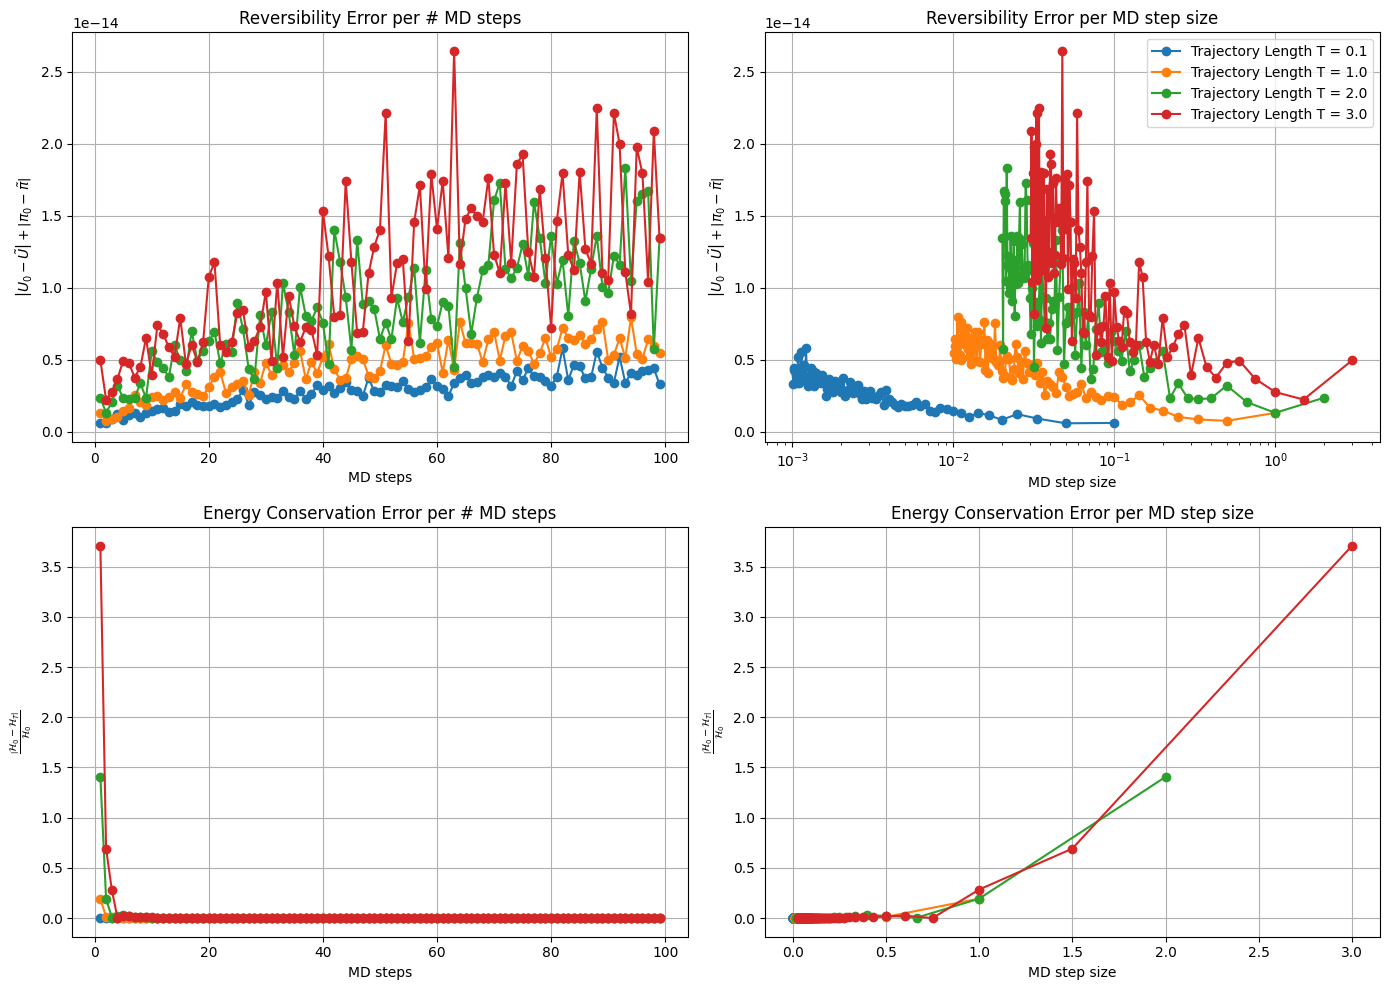

CPU times: user 3.58 s, sys: 216 ms, total: 3.79 s
Wall time: 3.6 s


In [14]:
%%time
np.random.seed(1234)
MD_traj_lengths = np.array([0.1,1.0,2.0,3.0])
MD_steps   = np.arange(1,100)

init_gauge = test_gauge
init_pi = np.random.normal(0,1/3,size=(3,3,2))

initial_energy = g_hamilton(1/3,init_gauge,init_pi)

errors_energy_conservation = np.zeros(shape=(len(MD_steps),len(MD_traj_lengths)))
errors_reversibility = np.zeros(shape=(len(MD_steps),len(MD_traj_lengths)))

for (Ts_i,Ts),(T_i,T) in it.product(enumerate(MD_steps),enumerate(MD_traj_lengths)):

    U,pi = g_leapfrog(
        beta = 1/3,
        init_gauge = init_gauge,
        init_pi = init_pi,
        MD_steps = Ts, 
        MD_trajectory_length = T, 
        MD_direction = 1
    )
    
    errors_energy_conservation[Ts_i,T_i] = np.abs( initial_energy - g_hamilton(1/3,U,pi) ) / initial_energy

    U_back,pi_back = g_leapfrog(
        beta = 1/3,
        init_gauge = U,
        init_pi = pi,
        MD_steps = Ts, 
        MD_trajectory_length = T, 
        MD_direction = -1
    )
    
    errors_reversibility[Ts_i,T_i] = np.sqrt(np.sum(pow(np.abs(U_back - init_gauge),2))) \
                                   + np.sqrt(np.sum(pow(pi_back - init_pi,2)))
    
fig,ax = plt.subplots(2,2,figsize = (14,10))
    
for T_i,T in enumerate(MD_traj_lengths):
    # Reversibility plots
    ax[0][0].plot(MD_steps,errors_reversibility[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    ax[0][1].plot(T/MD_steps,errors_reversibility[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    # Energy conservation plots
    ax[1][0].plot(MD_steps,errors_energy_conservation[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    ax[1][1].plot(T/MD_steps,errors_energy_conservation[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    

ax[0][0].set_xlabel("MD steps")
ax[1][0].set_xlabel("MD steps")
ax[0][1].set_xlabel(r"MD step size")
ax[1][1].set_xlabel(r"MD step size")

ax[0][0].set_ylabel(r"$\left\vert U_0 - \tilde{U} \right\vert + \left\vert \pi_0 - \tilde{\pi} \right\vert$")
ax[0][1].set_ylabel(r"$\left\vert U_0 - \tilde{U} \right\vert + \left\vert \pi_0 - \tilde{\pi} \right\vert$")
ax[1][0].set_ylabel(r"$\frac{\left\vert \mathcal{H}_{0} - \mathcal{H}_{T}\right\vert}{\mathcal{H}_{0}}$")
ax[1][1].set_ylabel(r"$\frac{\left\vert \mathcal{H}_{0} - \mathcal{H}_{T}\right\vert}{\mathcal{H}_{0}}$")

ax[0][0].set_title("Reversibility Error per # MD steps")
ax[0][1].set_title("Reversibility Error per MD step size")
ax[1][0].set_title("Energy Conservation Error per # MD steps")
ax[1][1].set_title("Energy Conservation Error per MD step size")

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()
ax[0][1].legend()

ax[0][1].set_xscale('log')

fig.tight_layout()
plt.show()

It is strait forward to check that 
\begin{equation}
\left.\frac{\left\vert \mathcal{H}_{0} - \mathcal{H}_{T}\right\vert}{\mathcal{H}_{0}} \right\vert_{\delta t} \sim \delta t^2
\end{equation}
by fitting the resulting error. 

Can you verify the behaviour?

We can see that the reversibility Error has a precision of $10^{-14}$ and the Energy conservation 
grows quadratically with the step size.

T = 0.1
T = 1.0
T = 2.0
T = 3.0


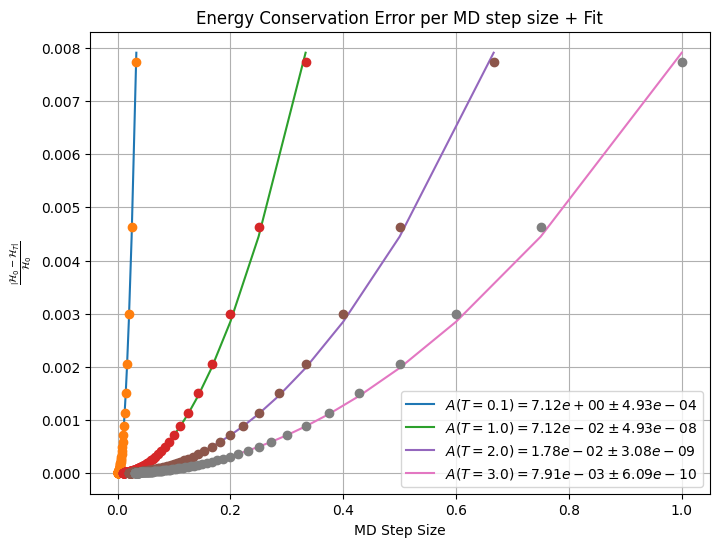

In [17]:
def f (x,A):
    return A*x*x

fig,ax = plt.subplots(1,1,figsize = (8,6))

# The first 3 points i.e. MD_steps = 1,2,3 can be neglect as they will not five a good accuracy regardless.
start_fit = 3

for T in MD_traj_lengths:
    print(f"T = {T}")
    # col = next(ax._get_lines.prop_cycler)['color']
    popt,pcov = curve_fit(f,T/np.arange(start_fit,100),errors_energy_conservation[start_fit-1:,1],p0=1)
    fit = f (T/np.arange(start_fit,100),*popt)
    # ax.plot(T/np.arange(start_fit,100),fit,color=col,label=rf"$A(T = {T}) = {popt[0]:.2e} \pm {pcov[0][0]:.2e}$")
    ax.plot(T/np.arange(start_fit,100),fit,label=rf"$A(T = {T}) = {popt[0]:.2e} \pm {pcov[0][0]:.2e}$")
    # ax.plot(T/np.arange(start_fit,100),errors_energy_conservation[start_fit-1:,1],'o',color=col)
    ax.plot(T/np.arange(start_fit,100),errors_energy_conservation[start_fit-1:,1],'o')

plt.legend()
plt.grid()
plt.title("Energy Conservation Error per MD step size + Fit")
plt.xlabel("MD Step Size")
plt.ylabel(r"$\frac{\left\vert \mathcal{H}_{0} - \mathcal{H}_{T}\right\vert}{\mathcal{H}_{0}}$")
plt.show()

##### Exercise 7.6

Now that we have the leapfrog it is not far to have the full HMC algorithm
```
    Generate initial data: U ~ e^{i N(0,1)}
    for conf_id = 1,2,... num_configs-1:
        Generate initial momentum: pi ~ N(0,1)
        Compute H_old = H(U,pi)
        U_proposal,pi_proposal = leapfrog(U,pi)
        Compute H_new = H(U_proposal,pi_proposal)
        
        if accept:
            markov_chain[conf_id] = U_proposal
        else:
            markov_chain[conf_id] = markov_chain[conf_id-1]
            
    return markov_chain, action_value, acceptence_rate
```

In [24]:
np.random.seed(1234)

def HMC(beta,Nt,Nx,num_configs,MD_steps=10,MD_trajectory_length=1):
# Exercise 7.6
# =============================================================================================================
    markov_chain = np.zeros(shape=(num_configs, Nt, Nx, 2), dtype=np.complex128)
    action_value = np.zeros(shape=num_configs)
    
    # generate the first gauge configuration and compute its action value
    markov_chain[0] = np.exp(1j * np.random.rand(Nt, Nx, 2))
    action_value[0] = g_action(beta,markov_chain[0])
    
    # we monitor the acceptence rate of the HMC
    acceptence = 1
    
    for conf_id in range(1,num_configs):
        # generate initial momentum condition
        pi = np.random.rand(Nt, Nx, 2)
        
        # compute the initial energy
        E = g_hamilton(beta, markov_chain[conf_id - 1], pi)
        
        # evolve the configurations along the EoM
        new_config, new_pi = g_leapfrog(beta, markov_chain[conf_id - 1], pi, MD_steps, MD_trajectory_length)

        # compute the resulting energy
        E = g_hamilton(beta, new_config, new_pi) - E
        
        # Accept/Reject
        if min(np.exp(-E), 1) >= np.random.rand():
            acceptence += 1
            markov_chain[conf_id] = new_config
        else:
            markov_chain[conf_id] = markov_chain[conf_id - 1].copy()
# =============================================================================================================            

    return markov_chain, action_value, acceptence/num_configs

The following two cells demonstrate how one could monitor the HMC. Typically one has a simple observable which is depending on the problem you want to analyse. Here we use the plaquette. 
The HMC is run for different parameters but only a few trajectories. Try to get a feeling on how the parameters change the acceptence rate and observables.

In [29]:
%%time

# play with these parameters and see what happens to the execution time and plots in the next cell
Nt = 16
Nx = 16
beta = 2
num_configs = 100

MD_traj_lengths = np.array([0.1,0.5,1.0,1.5,2.0])
MD_steps   = np.array([5,10,15,20,40,60,80,100])#np.arange(1,100,20)

acceptences = np.zeros(shape=(len(MD_steps),len(MD_traj_lengths)))
actions = np.zeros(shape=(len(MD_steps),len(MD_traj_lengths),num_configs))
plaquettes = np.zeros(shape=(len(MD_steps),len(MD_traj_lengths)),dtype=complex)

for (Ts_i,Ts),(T_i,T) in it.product(enumerate(MD_steps),enumerate(MD_traj_lengths)):
    ensamble, actions[Ts_i,T_i,:], acceptences[Ts_i,T_i] = HMC(beta,Nt,Nx,num_configs,MD_steps=Ts,MD_trajectory_length=T)
    plaquettes[Ts_i,T_i] = np.array([0.25*(g_plaquette(conf,mu_t,mu_x)+g_plaquette(conf,mu_x,mu_t)+g_plaquette(conf,mu_t,mu_t)+g_plaquette(conf,mu_x,mu_x)).sum() for conf in ensamble]).mean()

CPU times: user 15.9 s, sys: 158 µs, total: 15.9 s
Wall time: 15.9 s


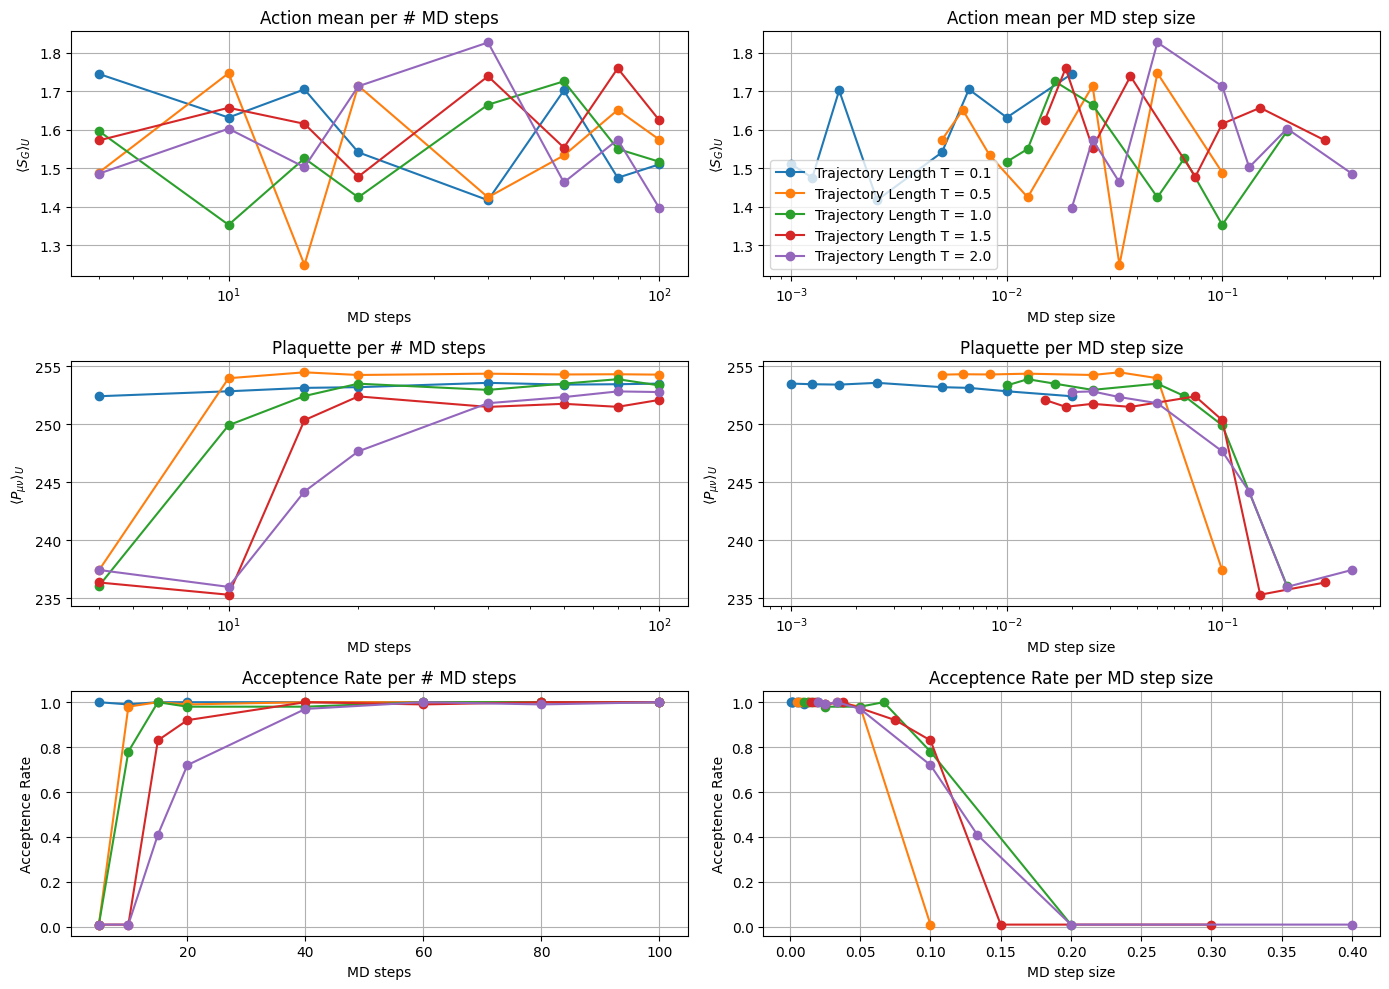

In [30]:
fig,ax = plt.subplots(3,2,figsize = (14,10))

for T_i,T in enumerate(MD_traj_lengths):
    # Actions
    ax[0][0].plot(MD_steps,np.mean(actions[:,T_i,:],axis=-1), 'o-', label = f"Trajectory Length T = {T}")
    ax[0][1].plot(T/MD_steps,np.mean(actions[:,T_i,:],axis=-1), 'o-', label = f"Trajectory Length T = {T}")
    # Plaquette
    ax[1][0].plot(MD_steps,plaquettes[:,T_i].real, 'o-', label = f"Trajectory Length T = {T}")
    ax[1][1].plot(T/MD_steps,plaquettes[:,T_i].real, 'o-', label = f"Trajectory Length T = {T}")
    # Acceptence rate
    ax[2][0].plot(MD_steps,acceptences[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    ax[2][1].plot(T/MD_steps,acceptences[:,T_i], 'o-', label = f"Trajectory Length T = {T}")
    

ax[0][0].set_xlabel("MD steps")
ax[1][0].set_xlabel("MD steps")
ax[2][0].set_xlabel("MD steps")
ax[0][1].set_xlabel(r"MD step size")
ax[1][1].set_xlabel(r"MD step size")
ax[2][1].set_xlabel(r"MD step size")

ax[0][0].set_ylabel(r"$\left\langle S_G \right\rangle_U$")
ax[0][1].set_ylabel(r"$\left\langle S_G \right\rangle_U$")
ax[1][0].set_ylabel(r"$\left\langle P_{\mu\nu} \right\rangle_U$")
ax[1][1].set_ylabel(r"$\left\langle P_{\mu\nu} \right\rangle_U$")
ax[2][0].set_ylabel(r"Acceptence Rate")
ax[2][1].set_ylabel(r"Acceptence Rate")

ax[0][0].set_title("Action mean per # MD steps")
ax[0][1].set_title("Action mean per MD step size")
ax[1][0].set_title("Plaquette per # MD steps")
ax[1][1].set_title("Plaquette per MD step size")
ax[2][0].set_title("Acceptence Rate per # MD steps")
ax[2][1].set_title("Acceptence Rate per MD step size")

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()
ax[2][0].grid()
ax[2][1].grid()
ax[0][1].legend()

ax[0][0].set_xscale('log')
ax[0][1].set_xscale('log')
ax[1][0].set_xscale('log')
ax[1][1].set_xscale('log')

fig.tight_layout()
plt.show()